# One Layer Classifier

In [1]:
import numpy as np
import os
np.random.seed(20)

In [36]:
from sklearn import preprocessing
import pickle

class CIFAR10Data():
    def __init__(self):
        self.batches = {}
        self.dataset_dir = '../datasets/cifar-10-batches-py/'
        self.label_1hot_encoder = preprocessing.LabelBinarizer()
        self.label_1hot_encoder.fit([x for x in range(10)])
        
        
    def one_hot_encode(self, labels):
        return self.label_1hot_encoder.transform(labels).T
    

    def load_batch(self, batch_name):
        """Loads a data batch
        Args:
            filename (str): filename of the data batch to be loaded
        Returns:
            X (np.ndarray): data matrix (D, N)
            Y (np.ndarray): one hot encoding of the labels (N,)
        """
        filename = self.dataset_dir + batch_name
        with open(filename, 'rb') as f:
            dataDict = pickle.load(f, encoding='bytes')

            X = (dataDict[b"data"]).T
            y = dataDict[b"labels"]
            Y = self.one_hot_encode(y)

        return X, Y
    
    def load_batches(self, batch_names):
        batches = [self.load_batch(batch) for batch in batch_names]
        # check should be hstack or vstack - check shapes
        X = np.hstack([batch[0] for batch in batches])
        Y = np.hstack([batch[1] for batch in batches])
        return X, Y

In [93]:
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import urllib

class OneLayerClassifer:
    def __init__(self, n_classes, input_dim, batch_size=100, eta=0.001, n_epochs=20, lamda=0, loss='cross_entropy', delta=None):
        self.batch_size = batch_size # number of images in a batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.lamda = lamda
        
        # initialise weight matrix and bias
        self.W = np.random.normal(loc=0, scale=0.01, size=(n_classes, input_dim)) 
        self.b = np.random.normal(loc=0, scale=0.01, size=(n_classes,1))
        assert (loss == 'cross_entropy' or loss == 'svm')
        self.loss = loss
        self.delta = delta
        
        

    def normalise(self, train_X, val_X, test_X):
        ''' X has shape (d,n) where d = dimensionality of each image, n is number of images '''
        mean = np.mean(train_X, axis=1)
        std = np.std(train_X, axis=1)
        original_shape = train_X.shape
        # apply same transformation to all of the datasets using params from train set
        def _normalise_helper(a, m, s):
            return ((a.T - m.T) / s.T).T
        
        train_X = _normalise_helper(train_X, mean, std)
        val_X = _normalise_helper(val_X, mean, std)
        test_X = _normalise_helper(test_X, mean, std)
        return train_X, val_X, test_X

    
    def evaluate_classifier(self, X, W, b, debug=False):
        S = np.dot(W, X) + b
        P = self.softmax(S) # probabiliites
        predictions = np.argmax(P, axis=0)
        return P, predictions
    

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)
        # deal with overflow problem
#         return np.exp(x - np.max(x, axis=0)) / np.exp(x - np.max(x, axis=0)).sum(axis=0)
    

    def compute_accuracy(self, X, Y):
        ''' X is data (dim, N), y is gt (C, N), W is weight matrix, b is bias, Y is 1hot encoded labels'''
        _, pred = self.evaluate_classifier(X, self.W, self.b)
        lbls = np.argmax(Y, axis=0)
        accuracy = np.mean(pred == lbls)
        return pred, accuracy
    

    def compute_cost(self, X, Y, W, b):
        ''' 
            X: dxn (dimensionality by # images)
            Y: Kxn (no. classes one-hot encoded by # images)
            J: scalar corresponding to sum of loss of ntwks predictions of X relative to gt labels 
        '''
        P, _ = self.evaluate_classifier(X, W, b)
        N = X.shape[1]
        probabilities = np.reshape(P, (10, -1))
        ground_truth = np.reshape(Y, (10, -1))
        if self.loss == 'cross_entropy':
            #  loss function + regularisation term
            loss = -np.trace(Y*np.log(P)) / N
            loss = -np.sum(Y*np.log(P)) ; N
            J = loss + self.lamda * np.sum(W**2)
        elif self.loss == 'svm':
#             # Compute the margins
#             margins = np.maximum(0, (P-np.sum(P*Y, axis=0) + self.delta)*(1-Y))
#             # compute SVM cost = loss function + regularisation term
#             J = np.sum(margins)/N + self.lamda * np.sum(W**2)
            s = np.copy(P)
            sc = s.T[np.arange(s.shape[1]), np.argmax(Y, axis=0)].T

            margins = np.maximum(0, s - np.asarray(sc) + 1)
            margins.T[np.arange(N), np.argmax(Y, axis=0)] = 0

            mcsvm_loss = Y.shape[0] * np.mean(np.sum(margins, axis=1))

            cost = 1/N * mcsvm_loss + 0.5 * labda * np.sum(self.W**2)

            return cost
        else: 
            raise Exception('incorrect loss')
#         log_arg = np.multiply(Y, P).sum(axis=0)
#         log_arg[log_arg == 0] = np.finfo(float).eps
#         J = (1/N) * -np.log(log_arg).sum() + self.lamda * np.sum(W**2)
        return J
        
    

    def compute_grads_num(self, X, Y, W, b, lamda, h=1e-6):
        """ Converted from matlab code """
        no = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((no, 1));

        c = self.compute_cost(X, Y, W, b);

        for i in range(len(b)):
            b_try = np.array(b)
            b_try[i] += h
            c2 = self.compute_cost(X, Y, W, b_try)
            grad_b[i] = (c2-c) / h

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] += h
                
                c2 = self.compute_cost(X, Y, W_try, b)
                grad_W[i,j] = (c2-c) / h

        return grad_W, grad_b

    
    
    def compute_grads_num_slow(self, X, Y, P, W, b, lamda, h):
        """ Converted from matlab code """
        N = W.shape[0]
        D = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((N, 1));

        for i in range(len(b)):
            b_try = np.copy(b)
            b_try[i] -= h
            c1 = self.compute_cost(X, Y, W, b_try)

            b_try = np.copy(b)
            b_try[i] += h
            c2 = self.compute_cost(X, Y, W, b_try)

            grad_b[i] = (c2-c1) / (2*h)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = W
                W_try[i,j] -= h
                c1 = self.compute_cost(X, Y, W_try, b)

                W_try = W
                W_try[i,j] += h
                c2 = self.compute_cost(X, Y, W_try, b)

                grad_W[i,j] = (c2-c1) / (2*h)

        return grad_W, grad_b
    
    
    def compare_gradients(self, g_n, g_a, eps=0.000001):
        err = np.linalg.norm(g_a-g_n) / max(eps, np.linalg.norm(g_a) + np.linalg.norm(g_n))
        print('relative error', err)
        assert err < 10**-6
        return err
        
    
    def compute_gradients(self, X, Y, W, b):
        ''' computes gradients of the cost function wrt W and b for batch X '''
        batch_size = X.shape[1]

        # forward pass
        P, _ = self.evaluate_classifier(X, W, b)
        
        # backward pass
        if self.loss == 'cross_entropy':
            G = -(Y - P)
        else: # svm loss
            margins = np.maximum(0, (P-np.sum(P*Y, axis=0) + self.delta)*(1-Y))
            G = margins
            G[margins > 0] = 1
            y = np.argmax(Y, axis=0)
            G[y, np.arange(batch_size)] = -np.sum(G, axis=0)

#             G_row_sum = np.sum(G, axis=0)

#             G.T[np.arange(N), np.argmax(Y, axis=0)] = -G_row_sum.T
            
        
        # J = L(D,W,b) + lamda|W|^2
        # dJ/dW = dL/dW + 2 lambda |W| 
        grad_W = (np.dot(G, X.T) /  batch_size) + 2 * self.lamda * W
        grad_b = np.sum(G, axis=1) / batch_size
        grad_b = grad_b.reshape((grad_b.shape[0],1))
        return grad_W, grad_b
    
    
    def train(self, X, Y, random_shuffle=False, val_X=None, val_Y=None, get_accuracies_costs=False):
        n = X.shape[1]
        number_of_batches = int(n / self.batch_size)
        indices = np.arange(X.shape[1])
        if random_shuffle:
            print('Randomly shuffling')
        print('Loss function', self.loss)
        
        accuracies = {'train': [], 'val': []}
        costs = {'train': [], 'val': []}
        
        for epoch in range(self.n_epochs):
#             if (epoch % 10) == 0:
#                 print('epoch', epoch)
            if random_shuffle:
                np.random.shuffle(indices)
                X = np.take(X, indices, axis=1)
                Y = np.take(Y, indices, axis=1)
                
            for j in range(number_of_batches):
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
    
                # Perform MiniBatch Gradient Descent
                grad_W, grad_b = self.compute_gradients(Xbatch, Ybatch, self.W, self.b)
                self.W -= self.eta * grad_W
                self.b -= (self.eta *  grad_b)

            if get_accuracies_costs and epoch % 5 == 0 or (epoch == self.n_epochs-1):
                _, train_accuracy = self.compute_accuracy(X, Y)
                _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                accuracies['train'].append(train_accuracy)
                accuracies['val'].append(val_accuracy)
                train_cost = self.compute_cost(X, Y, self.W, self.b)
                val_cost = self.compute_cost(val_X, val_Y, self.W, self.b)
                costs['train'].append(train_cost)
                costs['val'].append(val_cost)
                
        return accuracies, costs
                
    def montage(self):
        """ Display the image for each label in W """
        fig, ax = plt.subplots(2,5)
        labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        for i in range(2):
            for j in range(5):
                im  = self.W[5*i+j,:].reshape(32,32,3, order='F')
                sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                sim = sim.transpose(1,0,2)
                ax[i][j].imshow(sim, interpolation='nearest')
                ax[i][j].set_title("y="+labels[5*i+j])
                ax[i][j].axis('off')
        plt.show()
        

## Classification using Cross-Entropy Loss
We first train the classifier using Batch 1 as the training dataset, Batch 2 as the validation set, and test_batch as the test dataset.


In [12]:
CIFARDATA = CIFAR10Data()
train_X, train_Y = CIFARDATA.load_batch('data_batch_1')
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

Let us check gradients are correct

In [27]:
def check_gradients_are_equal(clf, X_train, Y_train_1hot, num_samples=4):
    # choose random subset of num_samples to test on
    indices = np.arange(X_train.shape[1])
    np.random.shuffle(indices)
    indices = indices[:num_samples]
  
    X_a = np.take(X_train, indices, axis=1)
    Y_a = np.take(Y_train_1hot, indices, axis=1)
    X_n = np.copy(X_a)
    Y_n = np.copy(Y_a)
   
    W_copy = np.copy(clf.W)
    b_copy = np.copy(clf.b)
    
    grad_W_test_ana, grad_b_test_ana = clf.compute_gradients(X_a, Y_a, clf.W, clf.b)

    clf.W = np.copy(W_copy)
    clf.b = np.copy(b_copy)
    grad_W_test_num, grad_b_test_num = clf.compute_grads_num(X_n, Y_n, clf.W, clf.b, clf.lamda)

    # check whether they're similar
    clf.compare_gradients(grad_W_test_num, grad_W_test_ana)
  

In [563]:
n_classes = 10
input_dim = train_X.shape[0]
clf = OneLayerClassifer(n_classes, input_dim)
check_gradients_are_equal(clf, train_X, train_Y)

relative error 8.27014836230927e-11


Now that we know the gradients are correct, let's train the model using different parameter configurations.

###  Plots graphs for training and validation

In [159]:
# plot cost function and accuracy
def plot_costs_accuracies(accuracies, costs, epoch_jump=1):
    plt.subplot(1,2,1)
    epochs = np.arange(0,len(costs['train']))*epoch_jump
    plt.plot(epochs, costs['train'], 'g-', label='Train')
    plt.plot(epochs, costs['val'], 'r-', label='Validation')
    plt.title('Cost function')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid('on')

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracies['train'], 'g-', label='Train')
    plt.plot(epochs, accuracies['val'], 'r-', label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid('on')
    
    plt.show()




In [160]:
def train_model(params, datasets, plot_acc_costs=False):
    train_X, train_Y, val_X, val_Y, test_X , test_Y = datasets
    n_classes = 10
    input_dim = train_X.shape[0]
    random_shuffle = params['random_shuffle'] if 'random_shuffle' in params else False
    delta = params['delta'] if 'delta' in params else None
    loss = params['loss'] if 'loss' in params else 'cross_entropy'
    
    clf = OneLayerClassifer(n_classes, input_dim, params['batch_size'], params['eta'], params['n_epochs'], params['lamda'], loss=loss, delta=delta)
    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
    accuracies, costs = clf.train(train_X, train_Y, random_shuffle, get_accuracies_costs=plot_acc_costs, 
                                  val_X = val_X, val_Y = val_Y)
    print(plot_acc_costs)
    if plot_acc_costs:
        print('here')
        plot_costs_accuracies(accuracies, costs)
    # get image of weight matrix
    clf.montage()

    _, test_accuracy = clf.compute_accuracy(test_X, test_Y) # use lables to compute accuracy
    _, val_accuracy = clf.compute_accuracy(val_X, val_Y)
    print('test_accuracy', test_accuracy)
    return {'test_accuracy': test_accuracy, 'val_accuracy': val_accuracy}



In [112]:
base_params = {'batch_size':20, 'eta':0.001, 'n_epochs':40, 'lamda':0, 'random_shuffle': True}
train_model(base_params, datasets, plot_acc_costs=False)

test_accuracy 0.3778


{'test_accuracy': 0.3778, 'val_accuracy': 0.3727}

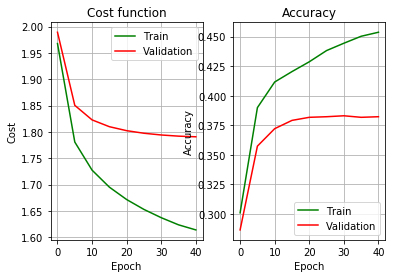

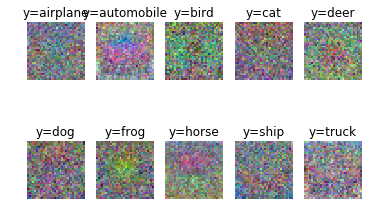

test_accuracy 0.3878


{'test_accuracy': 0.3878, 'val_accuracy': 0.3822}

In [119]:
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]
base_params = {'batch_size':100, 'eta':0.001, 'n_epochs':40, 'lamda':0, 'random_shuffle': False}
train_model(base_params, datasets, plot_acc_costs=True)

### Explore different Parameter Settings

{'lamda': 0, 'n_epochs': 40, 'batch_size': 100, 'eta': 0.1}
True
here


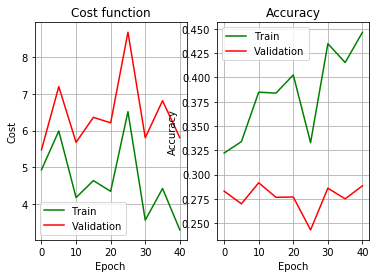

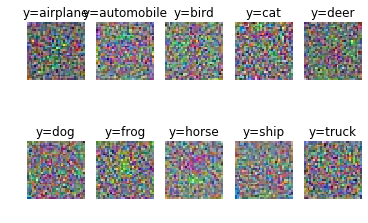

test_accuracy 0.2943
{'lamda': 0, 'n_epochs': 40, 'batch_size': 100, 'eta': 0.01}
True
here


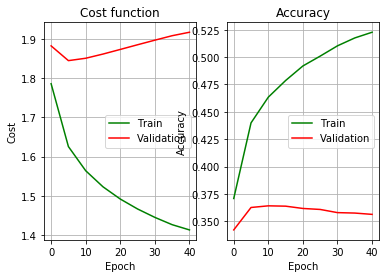

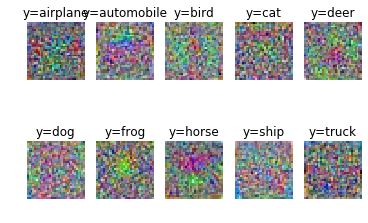

test_accuracy 0.3588
{'lamda': 0.1, 'n_epochs': 40, 'batch_size': 100, 'eta': 0.01}
True
here


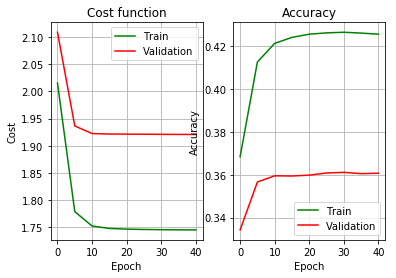

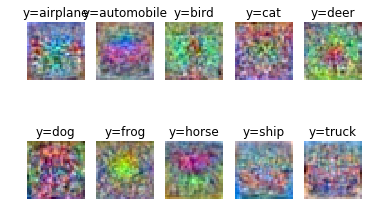

test_accuracy 0.3617
{'lamda': 1, 'n_epochs': 40, 'batch_size': 100, 'eta': 0.01}
True
here


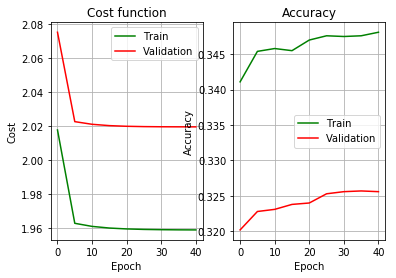

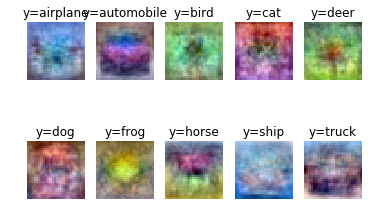

test_accuracy 0.326


,batch_size,eta,lamda,n_epochs,test_accuracy,val_accuracy
0,100,0.10,0.0,40,0.2943,0.2884
1,100,0.01,0.0,40,0.3588,0.3563
2,100,0.01,0.1,40,0.3617,0.3607
3,100,0.01,1.0,40,0.3260,0.3256


In [30]:
import pandas as pd 

params = [{'lamda': 0,   'n_epochs':  40, 'batch_size': 100, 'eta': .1},
            {'lamda': 0,   'n_epochs':  40, 'batch_size': 100, 'eta': .01},
            {'lamda': 0.1, 'n_epochs':  40, 'batch_size': 100, 'eta': .01},
            {'lamda': 1,   'n_epochs':  40, 'batch_size': 100, 'eta': .01},
        ]

test_results = []
for param in params:
    print(param)
    res = train_model(param, datasets, plot_acc_costs=True)
    test_results.append({**param, **res})
    
df_test = pd.DataFrame(test_results)
df_test

### Increasing Performance

We explore randomly shuffling the data at the start of every epoch, and running for more epochs.

{'lamda': 0.1, 'n_epochs': 40, 'batch_size': 100, 'eta': 0.01, 'random_shuffle': True, 'plot_acc_costs': False}
Randomly shuffling
False


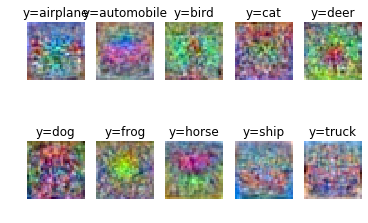

test_accuracy 0.3792
{'lamda': 0.1, 'n_epochs': 100, 'batch_size': 100, 'eta': 0.01, 'random_shuffle': False, 'plot_acc_costs': True}
True
here


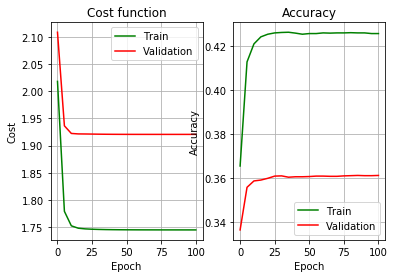

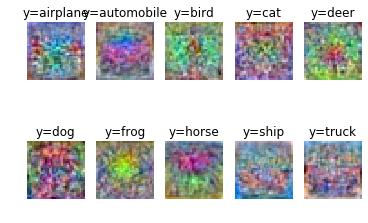

test_accuracy 0.3625
{'lamda': 0.1, 'n_epochs': 500, 'batch_size': 100, 'eta': 0.01, 'random_shuffle': False, 'plot_acc_costs': True}
True
here


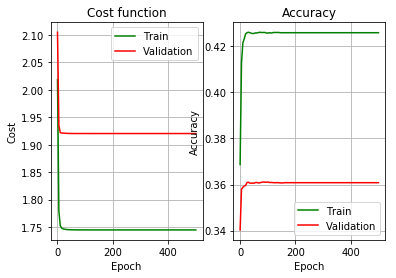

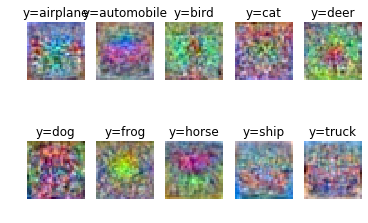

test_accuracy 0.3626


,batch_size,eta,lamda,n_epochs,plot_acc_costs,random_shuffle,test_accuracy,val_accuracy
0,100,0.01,0.1,40,False,True,0.3792,0.3763
1,100,0.01,0.1,100,True,False,0.3625,0.3611
2,100,0.01,0.1,500,True,False,0.3626,0.3608


In [31]:
params = [
            {'lamda': 0.1, 'n_epochs':  40, 'batch_size': 100, 'eta': .01, 'random_shuffle': True, 'plot_acc_costs': False},
            {'lamda': 0.1,   'n_epochs':  100, 'batch_size': 100, 'eta': .01, 'random_shuffle': False, 'plot_acc_costs': True},
            {'lamda': 0.1,   'n_epochs':  100, 'batch_size': 100, 'eta': .01, 'random_shuffle': True, 'plot_acc_costs': True},
        ]

test_results = []
for param in params:
    print(param)
    res = train_model(param, datasets, plot_acc_costs=param['plot_acc_costs'])
    test_results.append({**param, **res})
    
df_test = pd.DataFrame(test_results)
df_test

Use more training data - we set training data to batches 1, 3-5, validation set to batch 2.

In [41]:
CIFARDATA = CIFAR10Data()
train_X, train_Y = CIFARDATA.load_batches(['data_batch_1', 'data_batch_3', 'data_batch_4', 'data_batch_5'])
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

Randomly shuffling
True
here


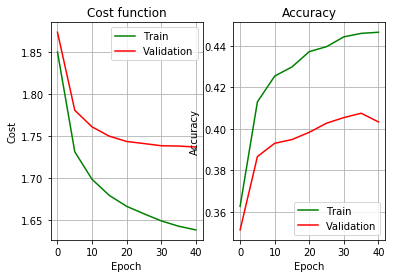

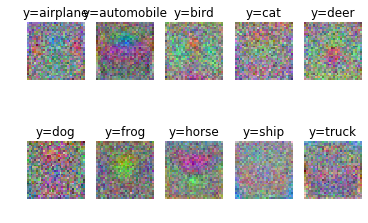

test_accuracy 0.4086


{'test_accuracy': 0.4086, 'val_accuracy': 0.4033}

In [42]:
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]
base_params = {'batch_size':100, 'eta':0.001, 'n_epochs':40, 'lamda':0, 'random_shuffle': True}
train_model(base_params, datasets, plot_acc_costs=True)

### SVM Loss

The SVM loss cost function is as follows:
$$J=\frac{1}{N}\sum_{i=1}^{N} \sum_{\underset{j\neq y^i}{j=1}}^{C} max(0,s_{ji}-s_{y^{i}i}+\delta) +\lambda\sum_{c,d}^{C,D}W_{ij}^2$$

In [47]:
# Reset the datasets 
CIFARDATA = CIFAR10Data()
train_X, train_Y = CIFARDATA.load_batch('data_batch_1')
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

In [157]:
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import urllib

class OneLayerClassifer:
    def __init__(self, n_classes, input_dim, batch_size=100, eta=0.001, n_epochs=20, lamda=0, loss='cross_entropy', delta=None):
        self.batch_size = batch_size # number of images in a batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.lamda = lamda
        
        # initialise weight matrix and bias
        self.W = np.random.normal(loc=0, scale=0.01, size=(n_classes, input_dim)) 
        self.b = np.random.normal(loc=0, scale=0.01, size=(n_classes,1))
        assert (loss == 'cross_entropy' or loss == 'svm')
        self.loss = loss
        self.delta = delta
        
        

    def normalise(self, train_X, val_X, test_X):
        ''' X has shape (d,n) where d = dimensionality of each image, n is number of images '''
        mean = np.mean(train_X, axis=1)
        std = np.std(train_X, axis=1)
        original_shape = train_X.shape
        # apply same transformation to all of the datasets using params from train set
        def _normalise_helper(a, m, s):
            return ((a.T - m.T) / s.T).T
        
        train_X = _normalise_helper(train_X, mean, std)
        val_X = _normalise_helper(val_X, mean, std)
        test_X = _normalise_helper(test_X, mean, std)
        return train_X, val_X, test_X

    
    def evaluate_classifier(self, X, W, b, debug=False):
        S = np.dot(W, X) + b
        P = self.softmax(S) # probabiliites
        predictions = np.argmax(P, axis=0)
        return P, predictions
    

    def softmax(self, x):
#         return np.exp(x) / np.sum(np.exp(x), axis=0)
        # deal with overflow problem
        return np.exp(x - np.max(x, axis=0)) / np.exp(x - np.max(x, axis=0)).sum(axis=0)
    

    def compute_accuracy(self, X, Y):
        ''' X is data (dim, N), y is gt (C, N), W is weight matrix, b is bias, Y is 1hot encoded labels'''
        _, pred = self.evaluate_classifier(X, self.W, self.b)
        lbls = np.argmax(Y, axis=0)
        accuracy = np.mean(pred == lbls)
        return pred, accuracy
    

    def compute_cost(self, X, Y, W, b):
        ''' 
            X: dxn (dimensionality by # images)
            Y: Kxn (no. classes one-hot encoded by # images)
            J: scalar corresponding to sum of loss of ntwks predictions of X relative to gt labels 
        '''
        P, _ = self.evaluate_classifier(X, W, b)
        N = X.shape[1]
        probabilities = np.reshape(P, (10, -1))
        ground_truth = np.reshape(Y, (10, -1))
        if self.loss == 'cross_entropy':
            #  loss function + regularisation term
            loss = -np.trace(Y*np.log(P)) / N
            loss = -np.sum(Y*np.log(P)) ; N
            J = loss + self.lamda * np.sum(W**2)
        elif self.loss == 'svm':
            margins = self.compute_margins(P, Y)
            J = 1/N * np.sum(margins) + self.lamda * np.sum(W**2)   
        else: 
            raise Exception('incorrect loss')

        return J
        
    

    def compute_grads_num(self, X, Y, W, b, lamda, h=1e-6):
        """ Converted from matlab code """
        no = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((no, 1));

        c = self.compute_cost(X, Y, W, b);

        for i in range(len(b)):
            b_try = np.array(b)
            b_try[i] += h
            c2 = self.compute_cost(X, Y, W, b_try)
            grad_b[i] = (c2-c) / h

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] += h
                
                c2 = self.compute_cost(X, Y, W_try, b)
                grad_W[i,j] = (c2-c) / h

        return grad_W, grad_b

    
    
    def compute_grads_num_slow(self, X, Y, P, W, b, lamda, h):
        """ Converted from matlab code """
        N = W.shape[0]
        D = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((N, 1));

        for i in range(len(b)):
            b_try = np.copy(b)
            b_try[i] -= h
            c1 = self.compute_cost(X, Y, W, b_try)

            b_try = np.copy(b)
            b_try[i] += h
            c2 = self.compute_cost(X, Y, W, b_try)

            grad_b[i] = (c2-c1) / (2*h)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = W
                W_try[i,j] -= h
                c1 = self.compute_cost(X, Y, W_try, b)

                W_try = W
                W_try[i,j] += h
                c2 = self.compute_cost(X, Y, W_try, b)

                grad_W[i,j] = (c2-c1) / (2*h)

        return grad_W, grad_b
    
    
    def compare_gradients(self, g_n, g_a, eps=0.000001):
        err = np.linalg.norm(g_a-g_n) / max(eps, np.linalg.norm(g_a) + np.linalg.norm(g_n))
        print('relative error', err)
        assert err < 10**-6
        return err
    
    def compute_margins(self, P, Y):
        ''' Computes margins for SVM loss'''
#         margins = np.maximum(0, (P-np.sum(P*Y, axis=0) + self.delta)*(1-Y))
        N = P.shape[1]
        sc = P[np.argmax(Y, axis=0), np.arange(N)]
        margins = np.maximum(0, P - np.asarray(sc) + self.delta)
        margins[np.argmax(Y, axis=0), np.arange(N)] = 0
        return margins
        
    
    def compute_gradients(self, X, Y, W, b):
        ''' computes gradients of the cost function wrt W and b for batch X '''
        N = X.shape[1]

        # forward pass
        P, _ = self.evaluate_classifier(X, W, b)
        
        # backward pass
        if self.loss == 'cross_entropy':
            G = -(Y - P)
        else: # svm loss
            margins = self.compute_margins(P, Y)

            G = margins
            G[margins > 0] = 1
            y = np.argmax(Y, axis=0)
            G[y, np.arange(N)] = -np.sum(G, axis=0)

        # J = L(D,W,b) + lamda|W|^2
        # dJ/dW = dL/dW + 2 lambda |W|    
        grad_W = (np.dot(G, X.T) /  N) + 2 * self.lamda * W    
        grad_b = np.sum(G, axis=1) / N
        grad_b = grad_b.reshape((grad_b.shape[0],1))

        return grad_W, grad_b
    
    
    def train(self, X, Y, random_shuffle=False, val_X=None, val_Y=None, get_accuracies_costs=False):
        n = X.shape[1]
        number_of_batches = int(n / self.batch_size)
        indices = np.arange(X.shape[1])
        if random_shuffle:
            print('Randomly shuffling')
        print('Loss function', self.loss)
        
        accuracies = {'train': [], 'val': []}
        costs = {'train': [], 'val': []}
        
        for epoch in range(self.n_epochs):
#             if (epoch % 10) == 0:
#                 print('epoch', epoch)
            if random_shuffle:
                np.random.shuffle(indices)
                X = np.take(X, indices, axis=1)
                Y = np.take(Y, indices, axis=1)
                
            for j in range(number_of_batches):
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
    
                # Perform MiniBatch Gradient Descent
                grad_W, grad_b = self.compute_gradients(Xbatch, Ybatch, self.W, self.b)
                self.W -= self.eta * grad_W
                self.b -= (self.eta *  grad_b)

            if get_accuracies_costs and epoch % 5 == 0 or (epoch == self.n_epochs-1):
                _, train_accuracy = self.compute_accuracy(X, Y)
                _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                accuracies['train'].append(train_accuracy)
                accuracies['val'].append(val_accuracy)
                train_cost = self.compute_cost(X, Y, self.W, self.b)
                val_cost = self.compute_cost(val_X, val_Y, self.W, self.b)
                costs['train'].append(train_cost)
                costs['val'].append(val_cost)
                
        return accuracies, costs
                
        
    def montage(self):
        """ Display the image for each label in W """
        fig, ax = plt.subplots(2,5)
        labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        for i in range(2):
            for j in range(5):
                im  = self.W[5*i+j,:].reshape(32,32,3, order='F')
                sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                sim = sim.transpose(1,0,2)
                ax[i][j].imshow(sim, interpolation='nearest')
                ax[i][j].set_title("y="+labels[5*i+j])
                ax[i][j].axis('off')
        plt.show()
        

Loss function svm
True
here


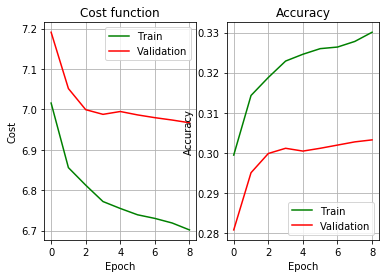

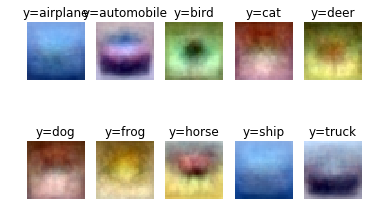

test_accuracy 0.3122


{'test_accuracy': 0.3122, 'val_accuracy': 0.3032}

In [161]:
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]
base_params = {'batch_size':100, 'eta':0.01, 'n_epochs':40, 'lamda':0, 'random_shuffle': False, 'loss':'svm', 'delta': 1}
train_model(base_params, datasets, plot_acc_costs=True)